In [1]:
import numpy as np
from DefineBoundaryFittedGeometries import define_geometry
from ShowMeshesForBoundaryFittedGeometries import show_mesh_for_boundary_fitted_geometries
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import grad


# Geometry

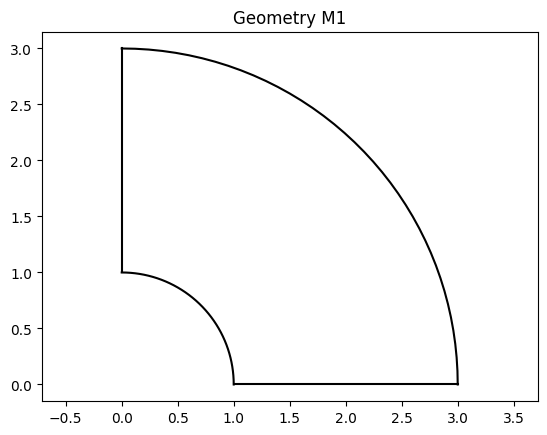

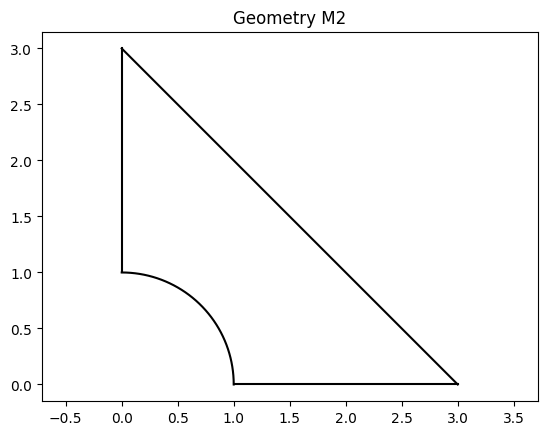

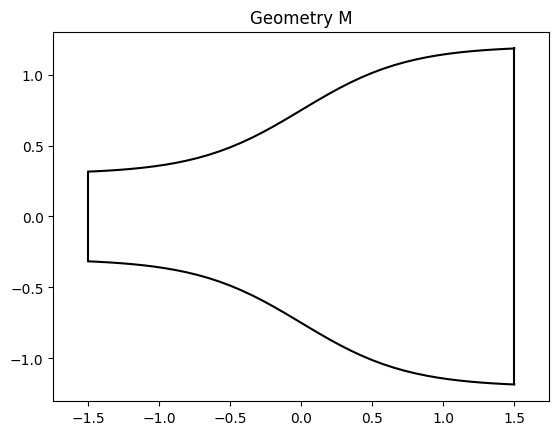

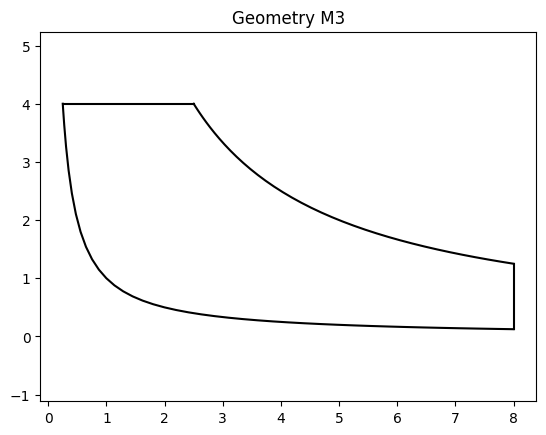

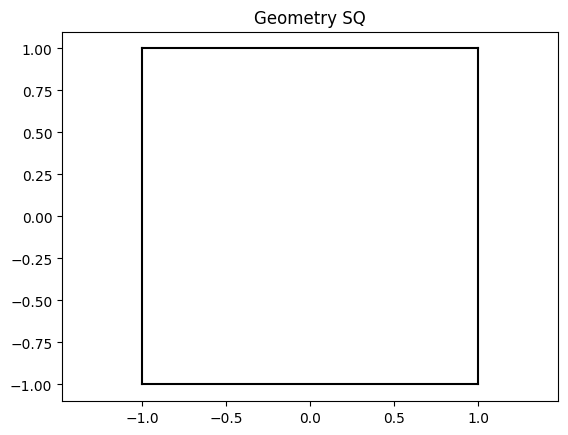

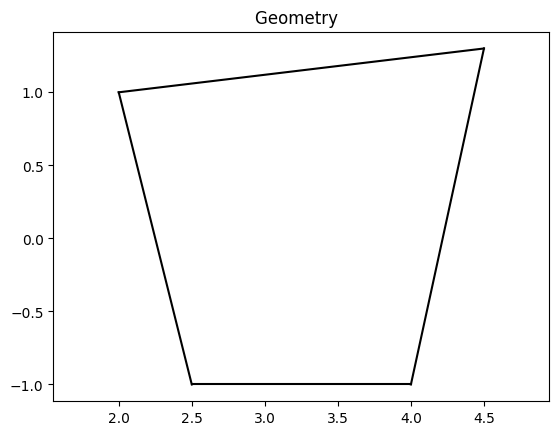

In [2]:
# Show available geometry shapes. 

for G in ['M1', 'M2', 'M', 'M3', 'SQ', ' ']:
    define_geometry(G, show_geometry=True)

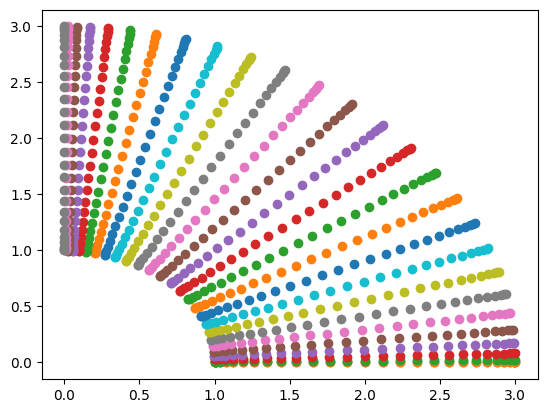

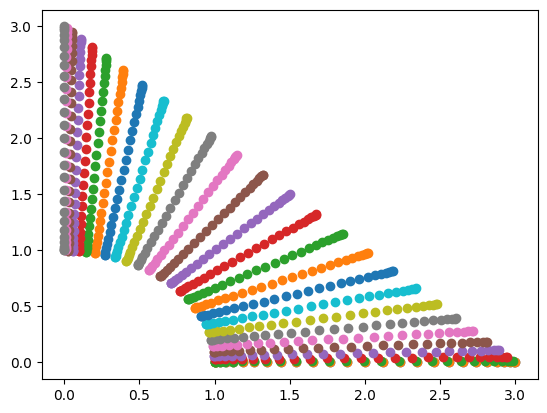

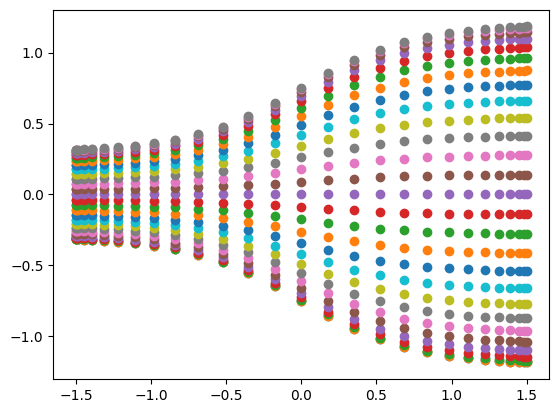

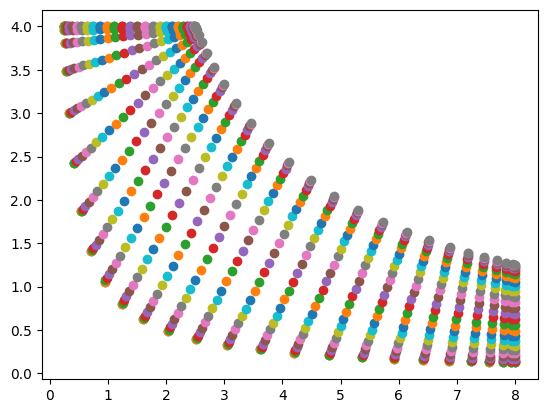

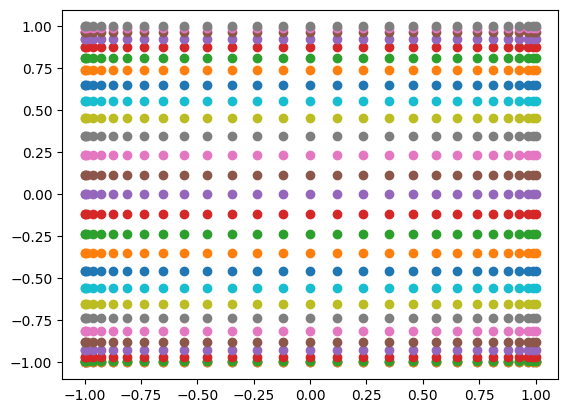

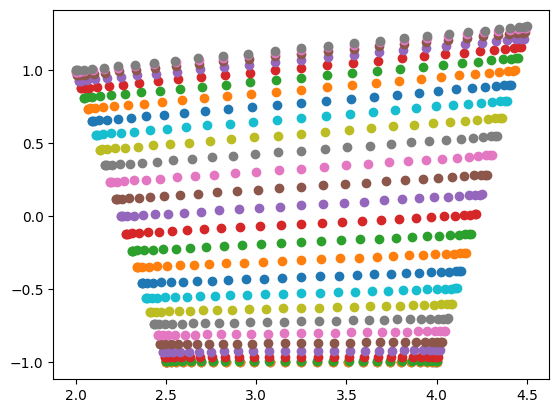

In [3]:
# Show the meshes/points for each geometry. 

for G in ['M1', 'M2', 'M', 'M3', 'SQ', ' ']:
    X, Y = show_mesh_for_boundary_fitted_geometries(G, print_on_off=False, plot=False)
    plt.figure()
    for i in range(X.shape[0]):
        plt.scatter(X[i], Y[i])
    plt.show()

In [4]:
# Define and sample geometry for physics loss. 
# NB: Code only tested for 'M1' geometry. 

geometry = 'M1' 

physics_xs, physics_ys = show_mesh_for_boundary_fitted_geometries(geometry)

In [5]:
# Create array of all coordinates. 

physics_xys = np.zeros((physics_xs.shape[0], physics_xs.shape[1], 2))
for i in range(physics_xs.shape[0]):
    physics_xys[i] = np.column_stack((physics_xs[i], physics_ys[i]))

physics_xys = np.reshape(physics_xys, (physics_xs.shape[0]*physics_xs.shape[1], 2))

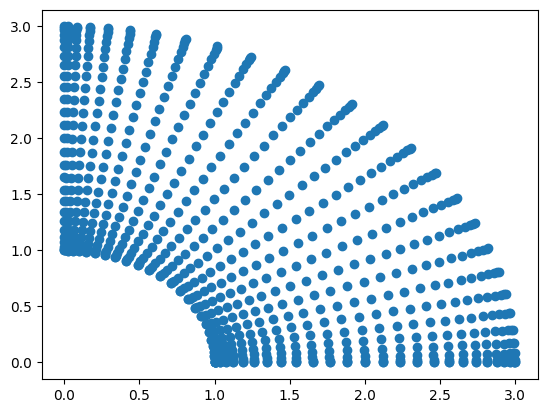

In [6]:
plt.scatter(physics_xys[:, 0], physics_xys[:, 1])
plt.show()

In [7]:
# Create interior array.

interior_xys = np.zeros((physics_xs.shape[0] - 2, physics_xs.shape[1] - 2, 2))
for i in range(physics_xs.shape[0]-2):
    interior_xys[i] = np.column_stack((physics_xs[i, 1:-1], physics_ys[i, 1:-1]))

interior_xys = np.reshape(interior_xys, ((physics_xs.shape[0] - 2) * (physics_xs.shape[1] - 2), 2))

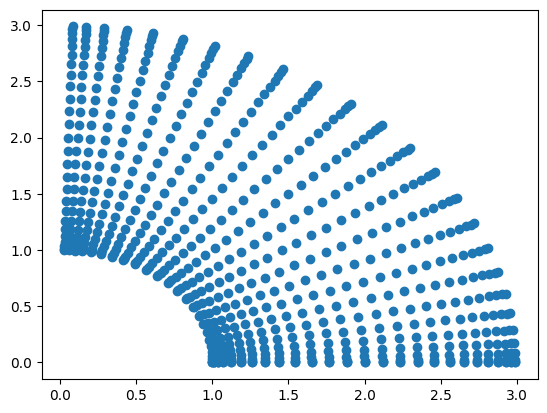

In [8]:
plt.scatter(interior_xys[:, 0], interior_xys[:, 1])
plt.show()

In [9]:
# Create inlet, outlet and walls arrays. 

inlet_xys = np.zeros((physics_xs[-1].shape[0], 2))
inlet_xys[:, 0] = physics_xs[-1]
inlet_xys[:, 1] = physics_ys[-1]

outlet_xys = np.zeros((physics_xs[0].shape[0], 2))
outlet_xys[:, 0] = physics_xs[0]
outlet_xys[:, 1] = physics_ys[0]

right_wall_xs = physics_xs[:, 0]
right_wall_ys = physics_ys[:, 0]

left_wall_xs = physics_xs[:, -1]
left_wall_ys = physics_ys[:, -1]

left_wall_xys = np.zeros((left_wall_xs.shape[0], 2))
left_wall_xys[:, 0] = left_wall_xs
left_wall_xys[:, 1] = left_wall_ys

right_wall_xys = np.zeros((right_wall_xs.shape[0], 2))
right_wall_xys[:, 0] = right_wall_xs
right_wall_xys[:, 1] = right_wall_ys

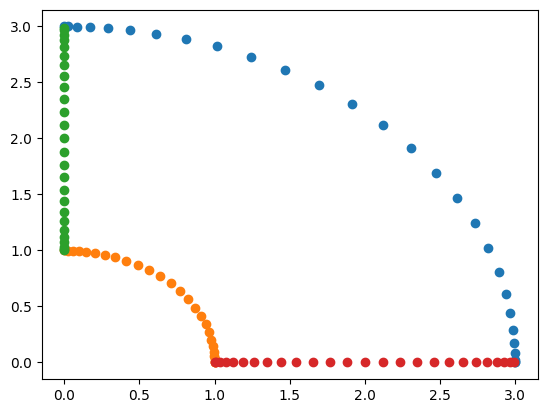

In [10]:
plt.scatter(left_wall_xys[:, 0], left_wall_xys[:, 1])
plt.scatter(right_wall_xys[:, 0], right_wall_xys[:, 1])
plt.scatter(inlet_xys[1:-1, 0], inlet_xys[1:-1, 1])
plt.scatter(outlet_xys[1:-1, 0], outlet_xys[1:-1, 1])
plt.show()

In [11]:
# Define network architecture.

class FullyConnected(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.input = nn.Sequential(
      nn.Linear(n_inputs, n_hidden),
      nn.Tanh(),
    )
    
    self.hidden = nn.Sequential(
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
    )

    self.output = nn.Sequential(
    nn.Linear(n_hidden, n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, n_outputs),
    )

  def forward(self, x):
    x = self.input(x)
    x = self.hidden(x)
    x = self.output(x)
    return x


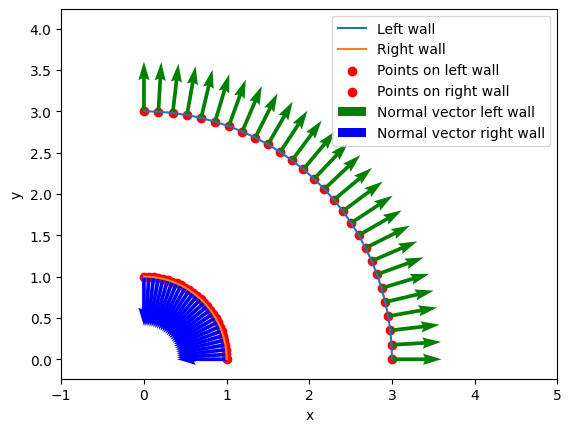

In [12]:
# Calculate normal vectors for the boundary condition.

ex = np.array([1, 0])
ey = np.array([0, 1])

gam1, _, gam2, _, gam3, _, gam4, _ = define_geometry('M1', show_geometry=False)

xi = np.linspace(-1, 1, 28) # Right wall points
eta = np.linspace(-1, 1, 28) # Left wall points

left_wall_xs, left_wall_ys = gam2(eta)
right_wall_xs, right_wall_ys = gam4(xi)

# Calculate the gradient of the boundary function at the chosen point
delta = 1e-6  # Small perturbation for numerical gradient calculation
df_dx_left = (gam2(eta + delta)[0] - gam2(eta - delta)[0]) / (2 * delta)
df_dy_left = (gam2(eta + delta)[1] - gam2(eta - delta)[1]) / (2 * delta)

df_dx_right = (gam4(xi + delta)[0] - gam4(xi - delta)[0]) / (2 * delta)
df_dy_right = (gam4(xi + delta)[1] - gam4(xi - delta)[1]) / (2 * delta)

# Construct the normal vector
normal_vectors_left = np.zeros((df_dx_left.shape[0], 2))
normal_vectors_right = np.zeros((df_dx_right.shape[0], 2))

normal_vectors_left[:, 0] = df_dy_left[:]
normal_vectors_left[:, 1] = -df_dx_left[:]

normal_vectors_right[:, 0] = -df_dy_right[:]
normal_vectors_right[:, 1] = df_dx_right[:]

norms_left = np.linalg.norm(normal_vectors_left, axis=1)
norms_right = np.linalg.norm(normal_vectors_right, axis=1)

normal_vectors_left = normal_vectors_left / norms_left[:, np.newaxis]
normal_vectors_right = normal_vectors_right / norms_right[:, np.newaxis]

# Plot the walls and the normal vectors
# plt.figure(figsize=(20, 20))
plt.plot(left_wall_xs, left_wall_ys, label='Left wall')
plt.plot(right_wall_xs, right_wall_ys, label='Right wall')
plt.scatter(left_wall_xs, left_wall_ys, color='red', label='Points on left wall')
plt.scatter(right_wall_xs, right_wall_ys, color='red', label='Points on right wall')
plt.quiver(left_wall_xs, left_wall_ys, normal_vectors_left[:, 0], normal_vectors_left[:, 1], color='green', scale=10, label='Normal vector left wall')
plt.quiver(right_wall_xs, right_wall_ys, normal_vectors_right[:, 0], normal_vectors_right[:, 1], color='blue', scale=10, label='Normal vector right wall')
plt.xlabel('x')
plt.ylabel('y')

plt.legend()
plt.axis('equal')
plt.xlim(-1, 5)
plt.ylim(-1, 5)
plt.show()


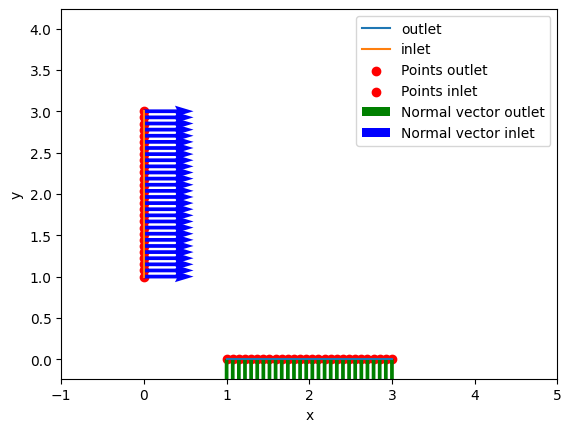

In [17]:
# Calculate normal vectors for the boundary condition.

ex = np.array([1, 0])
ey = np.array([0, 1])

gam1, _, gam2, _, gam3, _, gam4, _ = define_geometry('M1', show_geometry=False)

xi = np.linspace(-1, 1, 28) # Right wall points
eta = np.linspace(-1, 1, 28) # Left wall points

left_wall_xs, left_wall_ys = gam1(eta)
right_wall_xs, right_wall_ys = gam3(xi)

# Calculate the gradient of the boundary function at the chosen point
delta = 1e-6  # Small perturbation for numerical gradient calculation
df_dx_left = (gam1(eta + delta)[0] - gam1(eta - delta)[0]) / (2 * delta)
df_dy_left = (gam1(eta + delta)[1] - gam1(eta - delta)[1]) / (2 * delta)

df_dx_right = (gam3(xi + delta)[0] - gam3(xi - delta)[0]) / (2 * delta)
df_dy_right = (gam3(xi + delta)[1] - gam3(xi - delta)[1]) / (2 * delta)

# Construct the normal vector
normal_vectors_left = np.zeros((df_dx_left.shape[0], 2))
normal_vectors_right = np.zeros((df_dx_right.shape[0], 2))

normal_vectors_left[:, 0] = df_dy_left[:]
normal_vectors_left[:, 1] = -df_dx_left[:]

normal_vectors_right[:, 0] = df_dy_right[:]
normal_vectors_right[:, 1] = -df_dx_right[:]

norms_left = np.linalg.norm(normal_vectors_left, axis=1)
norms_right = np.linalg.norm(normal_vectors_right, axis=1)

normal_vectors_left = normal_vectors_left / norms_left[:, np.newaxis]
normal_vectors_right = normal_vectors_right / norms_right[:, np.newaxis]

# Plot the walls and the normal vectors
# plt.figure(figsize=(20, 20))
plt.plot(left_wall_xs, left_wall_ys, label='outlet')
plt.plot(right_wall_xs, right_wall_ys, label='inlet')
plt.scatter(left_wall_xs, left_wall_ys, color='red', label='Points outlet')
plt.scatter(right_wall_xs, right_wall_ys, color='red', label='Points inlet')
plt.quiver(left_wall_xs, left_wall_ys, normal_vectors_left[:, 0], normal_vectors_left[:, 1], color='green', scale=10, label='Normal vector outlet')
plt.quiver(right_wall_xs, right_wall_ys, normal_vectors_right[:, 0], normal_vectors_right[:, 1], color='blue', scale=10, label='Normal vector inlet')
plt.xlabel('x')
plt.ylabel('y')

plt.legend()
plt.axis('equal')
plt.xlim(-1, 5)
plt.ylim(-1, 5)
plt.show()


Step: 2000
PDE loss, boundary loss, data loss: (tensor(0.0006, grad_fn=<MeanBackward0>), tensor(3.1935e-06, grad_fn=<AddBackward0>), 0)


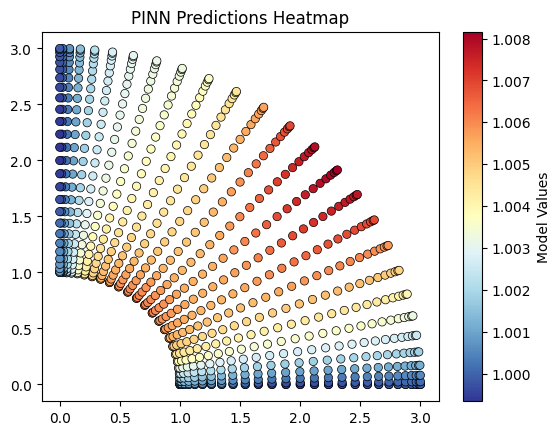

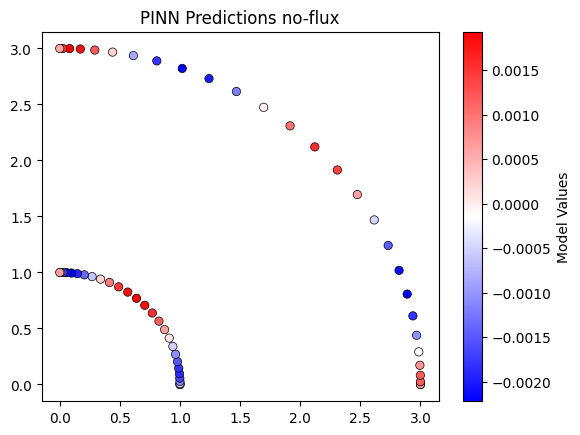

Step: 4000
PDE loss, boundary loss, data loss: (tensor(0.0002, grad_fn=<MeanBackward0>), tensor(2.8944e-07, grad_fn=<AddBackward0>), 0)


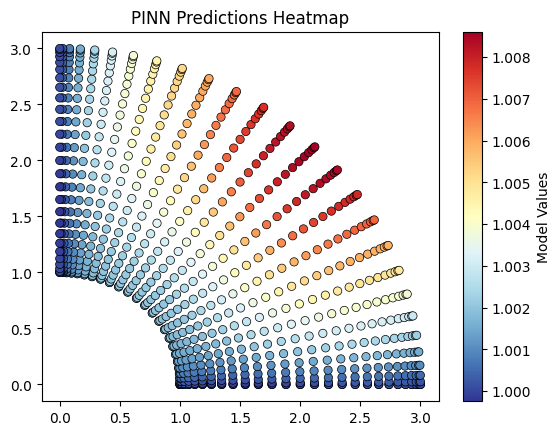

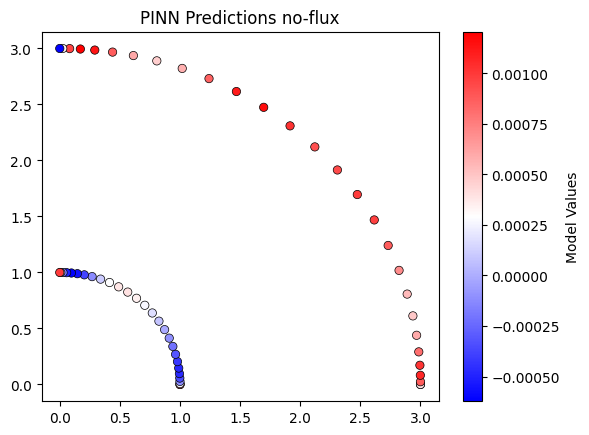

Step: 6000
PDE loss, boundary loss, data loss: (tensor(0.0002, grad_fn=<MeanBackward0>), tensor(1.7505e-07, grad_fn=<AddBackward0>), 0)


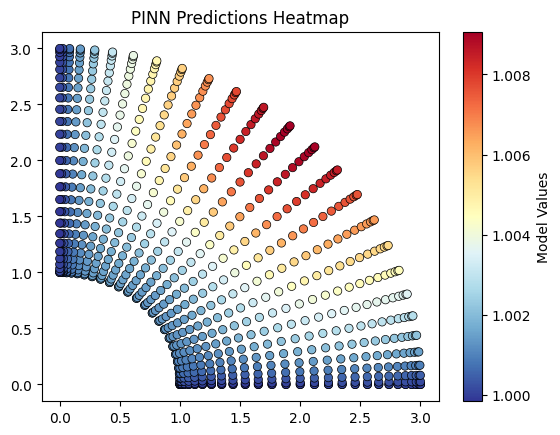

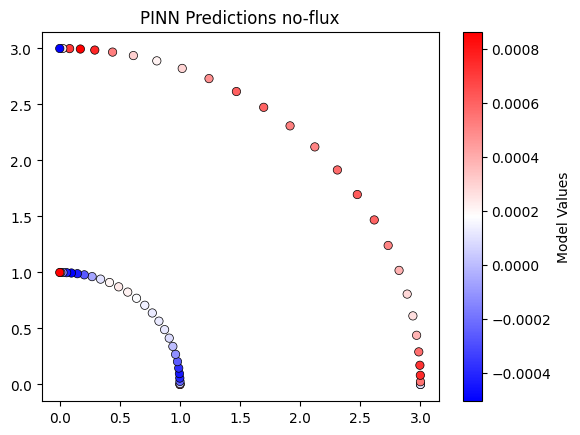

Step: 8000
PDE loss, boundary loss, data loss: (tensor(0.0001, grad_fn=<MeanBackward0>), tensor(1.2462e-07, grad_fn=<AddBackward0>), 0)


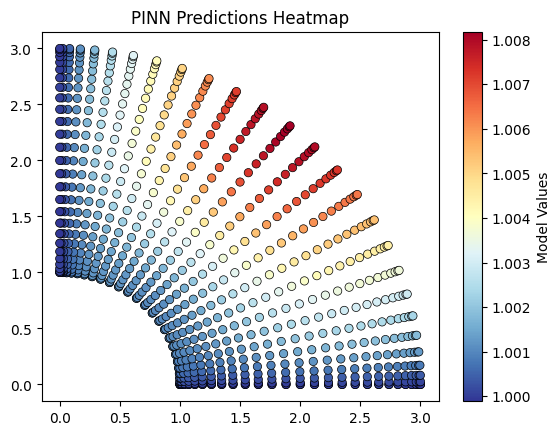

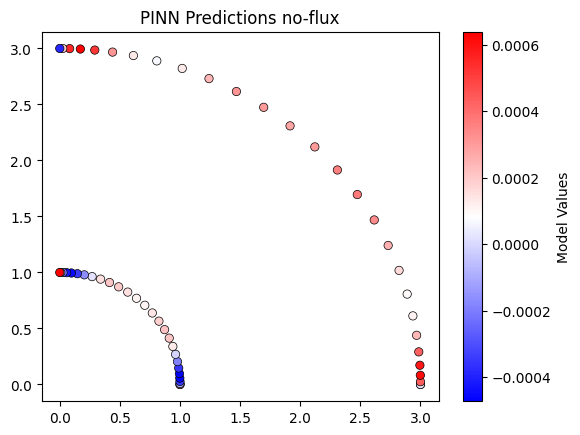

Step: 10000
PDE loss, boundary loss, data loss: (tensor(9.3586e-05, grad_fn=<MeanBackward0>), tensor(5.6550e-08, grad_fn=<AddBackward0>), 0)


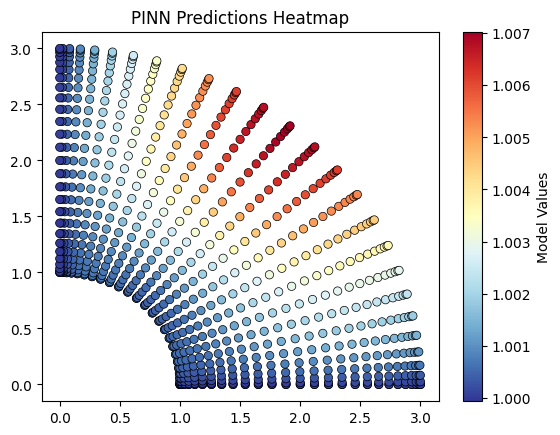

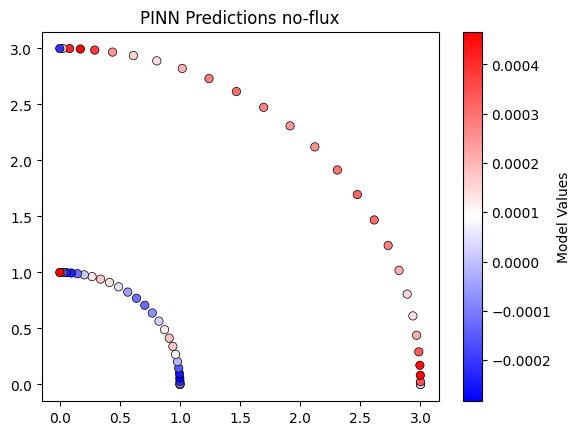

Step: 12000
PDE loss, boundary loss, data loss: (tensor(6.9819e-05, grad_fn=<MeanBackward0>), tensor(9.4771e-08, grad_fn=<AddBackward0>), 0)


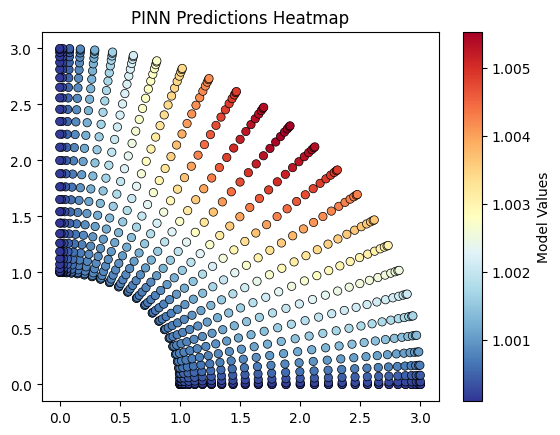

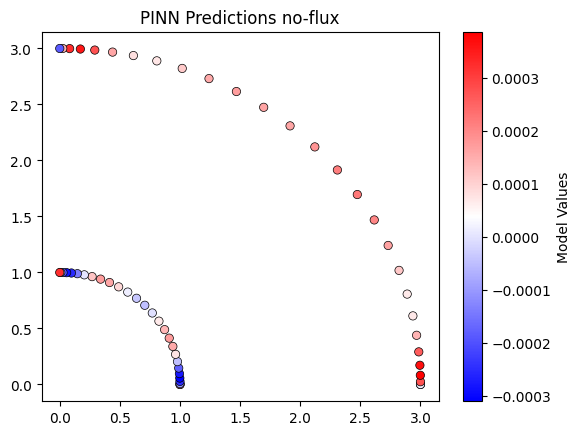

Step: 14000
PDE loss, boundary loss, data loss: (tensor(4.4257e-05, grad_fn=<MeanBackward0>), tensor(2.5924e-06, grad_fn=<AddBackward0>), 0)


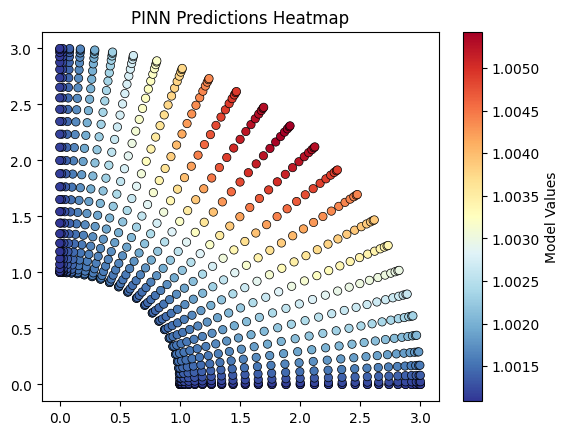

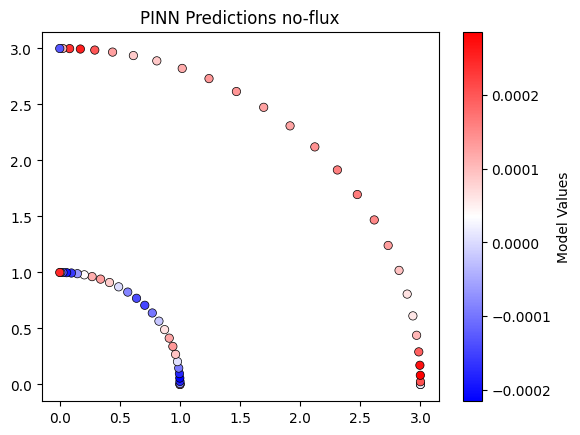

Step: 16000
PDE loss, boundary loss, data loss: (tensor(2.7871e-05, grad_fn=<MeanBackward0>), tensor(1.9052e-08, grad_fn=<AddBackward0>), 0)


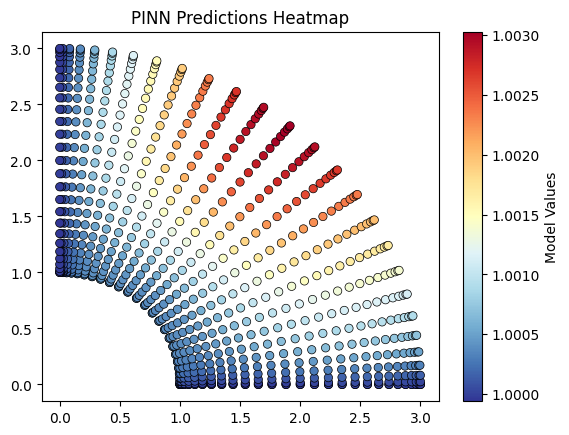

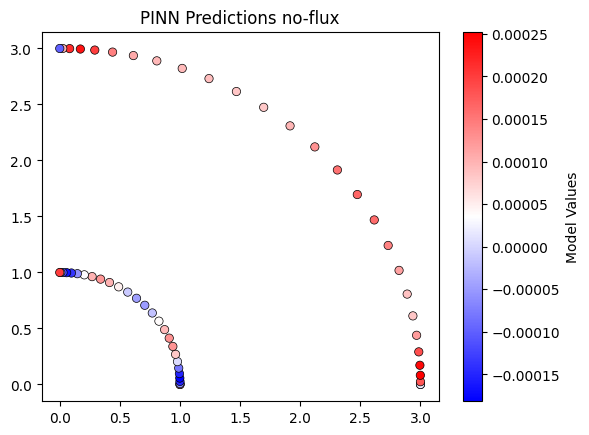

Step: 18000
PDE loss, boundary loss, data loss: (tensor(1.6303e-05, grad_fn=<MeanBackward0>), tensor(3.0632e-06, grad_fn=<AddBackward0>), 0)


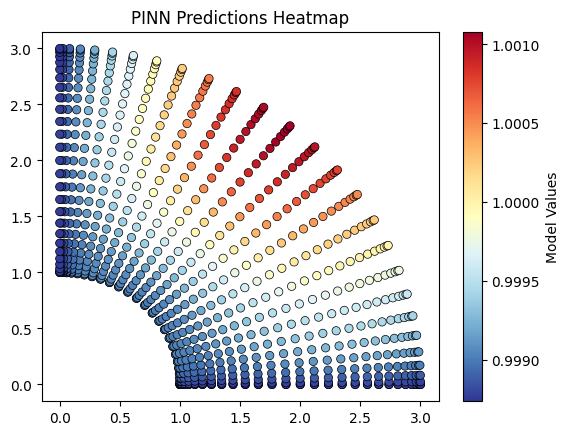

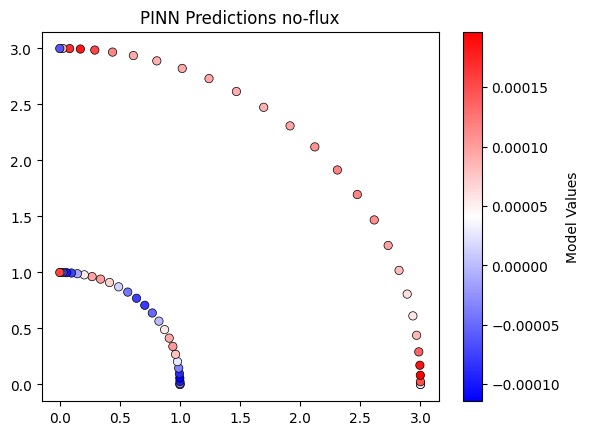

Step: 20000
PDE loss, boundary loss, data loss: (tensor(1.0465e-05, grad_fn=<MeanBackward0>), tensor(8.7605e-09, grad_fn=<AddBackward0>), 0)


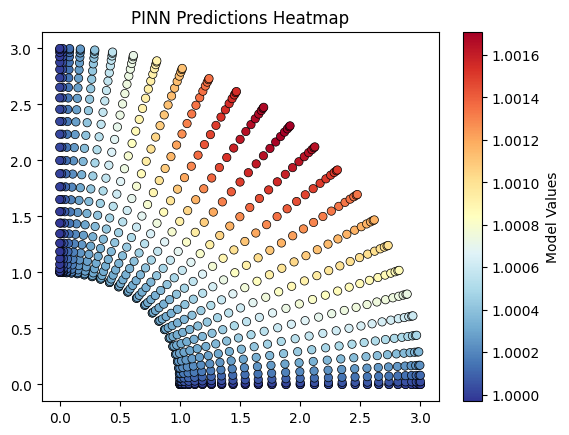

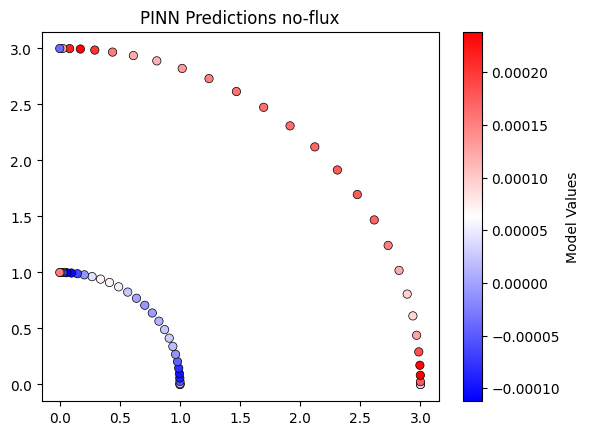

Step: 22000
PDE loss, boundary loss, data loss: (tensor(9.5525e-06, grad_fn=<MeanBackward0>), tensor(2.2556e-08, grad_fn=<AddBackward0>), 0)


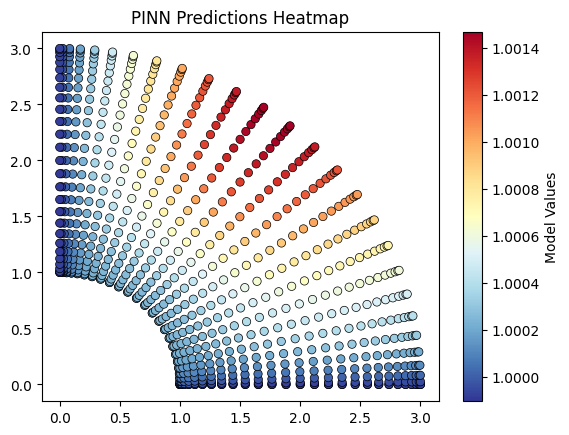

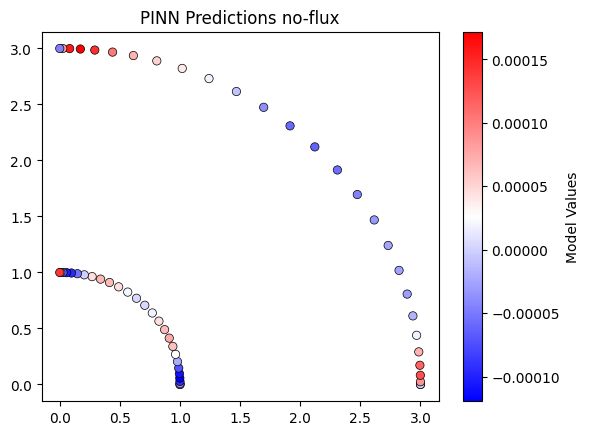

Step: 24000
PDE loss, boundary loss, data loss: (tensor(6.3809e-06, grad_fn=<MeanBackward0>), tensor(5.1037e-09, grad_fn=<AddBackward0>), 0)


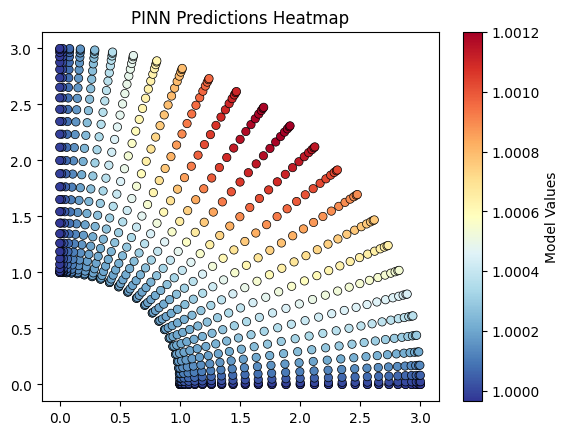

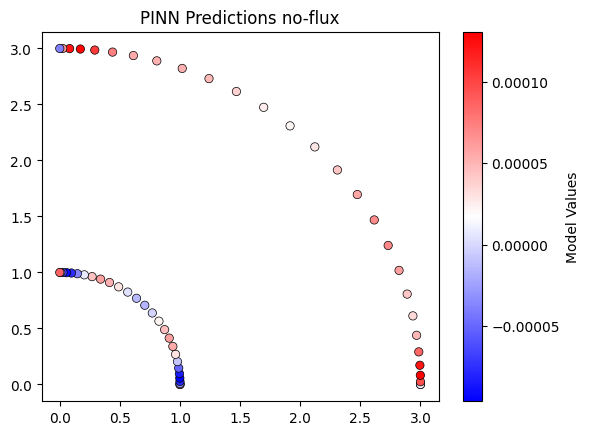

Step: 26000
PDE loss, boundary loss, data loss: (tensor(4.5781e-06, grad_fn=<MeanBackward0>), tensor(3.1156e-09, grad_fn=<AddBackward0>), 0)


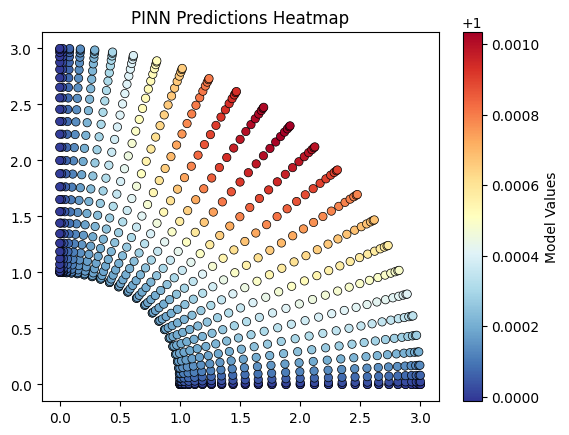

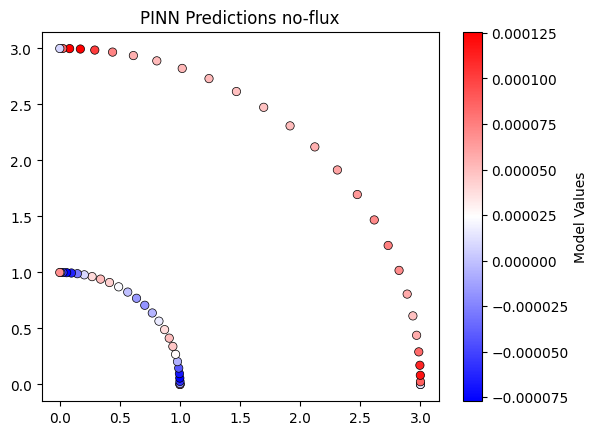

Step: 28000
PDE loss, boundary loss, data loss: (tensor(3.2951e-06, grad_fn=<MeanBackward0>), tensor(2.0120e-09, grad_fn=<AddBackward0>), 0)


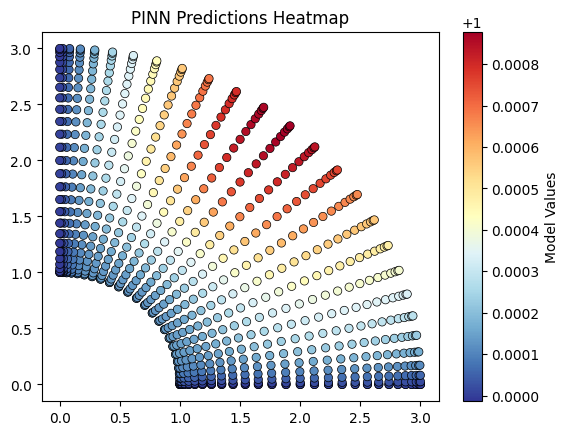

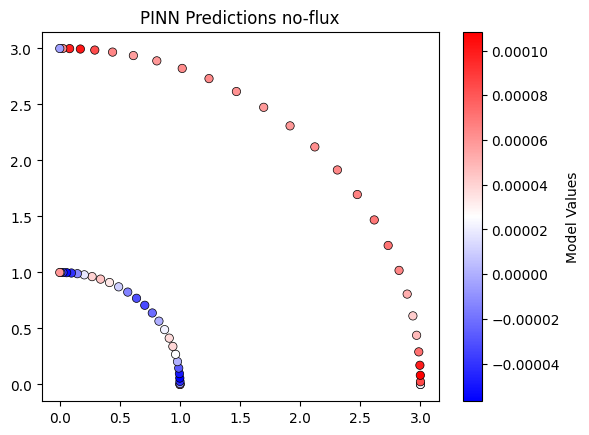

Step: 30000
PDE loss, boundary loss, data loss: (tensor(2.3103e-06, grad_fn=<MeanBackward0>), tensor(1.3649e-09, grad_fn=<AddBackward0>), 0)


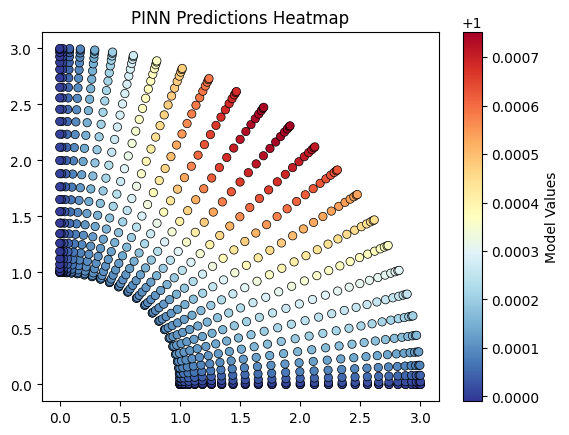

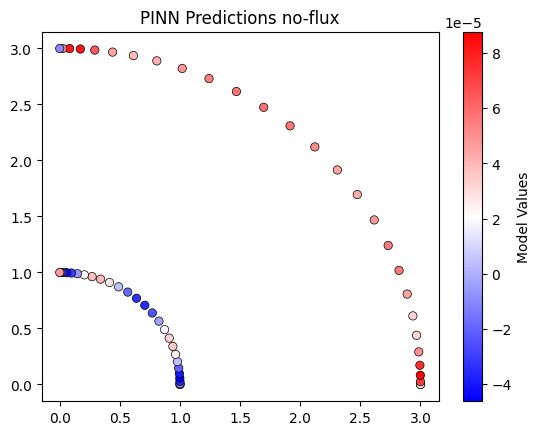

Step: 32000
PDE loss, boundary loss, data loss: (tensor(2.1388e-06, grad_fn=<MeanBackward0>), tensor(1.4244e-05, grad_fn=<AddBackward0>), 0)


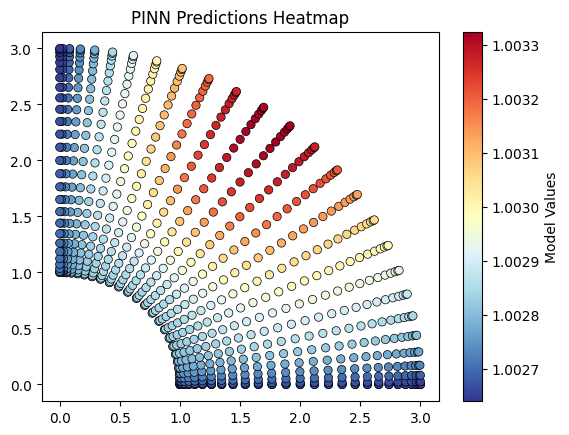

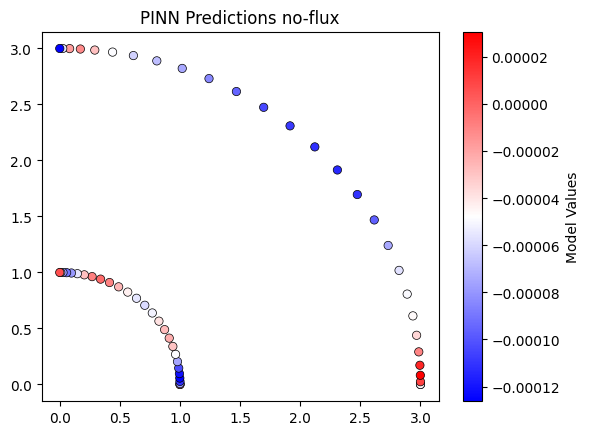

Step: 34000
PDE loss, boundary loss, data loss: (tensor(1.5337e-06, grad_fn=<MeanBackward0>), tensor(2.2153e-07, grad_fn=<AddBackward0>), 0)


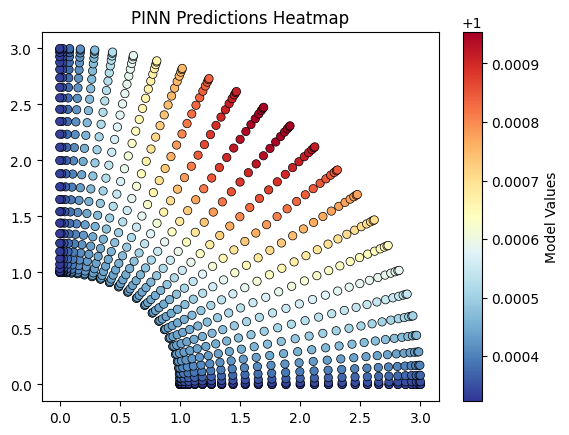

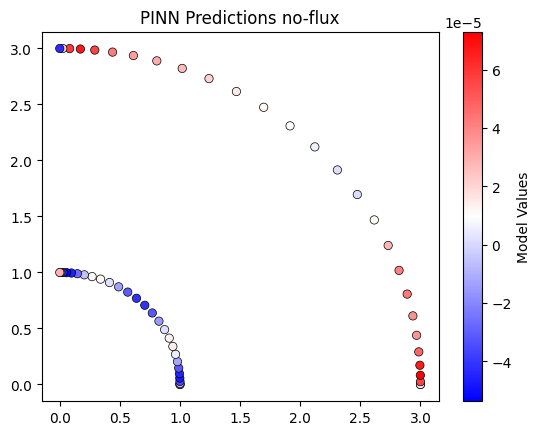

Step: 36000
PDE loss, boundary loss, data loss: (tensor(1.2945e-06, grad_fn=<MeanBackward0>), tensor(8.7637e-10, grad_fn=<AddBackward0>), 0)


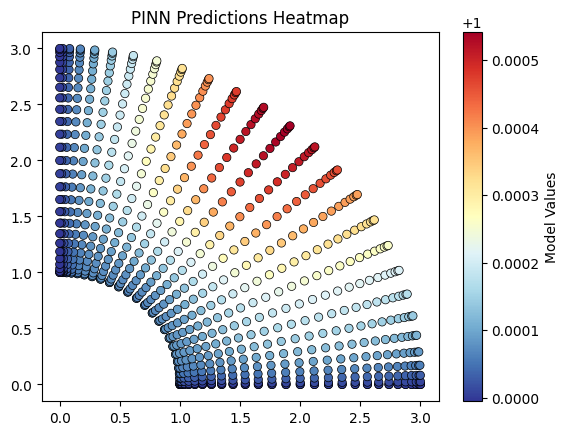

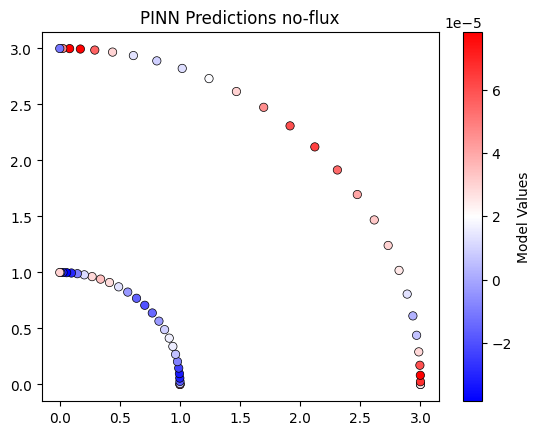

Step: 38000
PDE loss, boundary loss, data loss: (tensor(1.1782e-06, grad_fn=<MeanBackward0>), tensor(6.7066e-10, grad_fn=<AddBackward0>), 0)


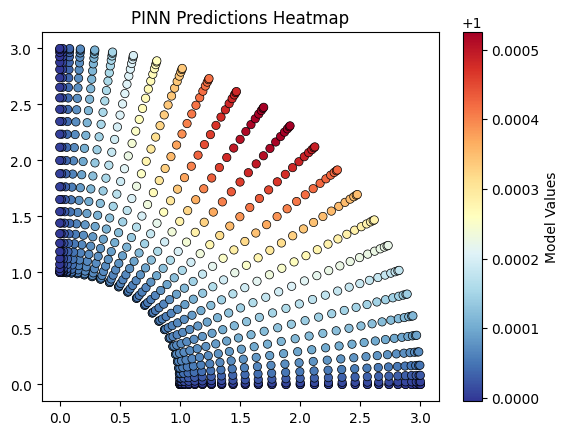

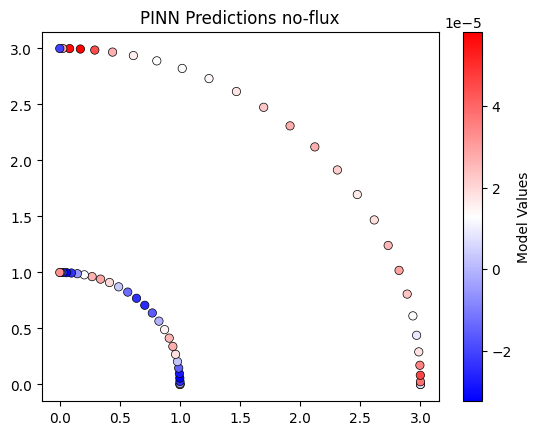

Step: 40000
PDE loss, boundary loss, data loss: (tensor(9.4978e-07, grad_fn=<MeanBackward0>), tensor(5.3483e-10, grad_fn=<AddBackward0>), 0)


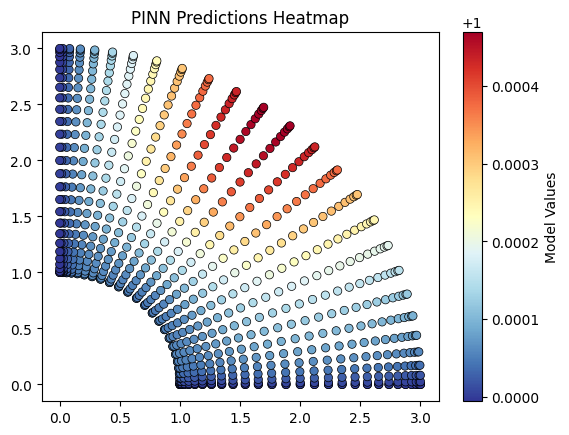

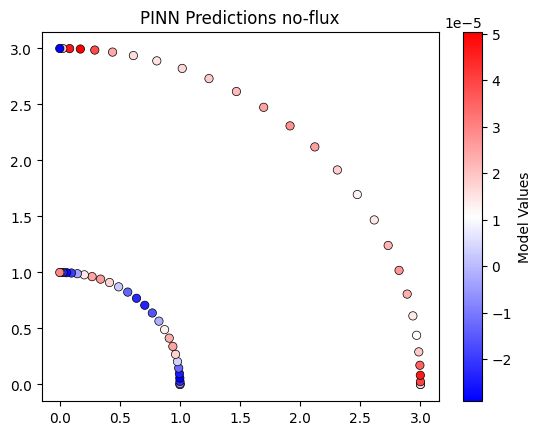

Step: 42000
PDE loss, boundary loss, data loss: (tensor(8.0218e-07, grad_fn=<MeanBackward0>), tensor(4.8535e-10, grad_fn=<AddBackward0>), 0)


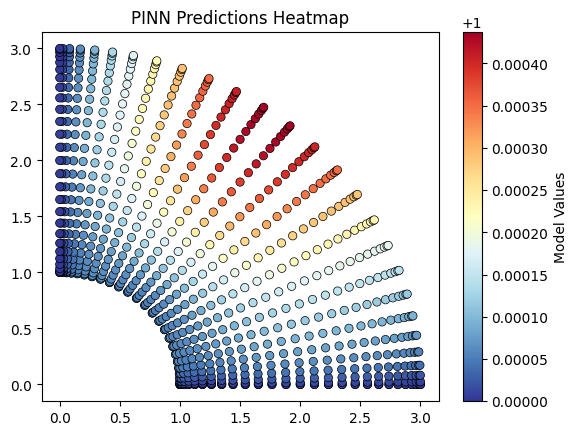

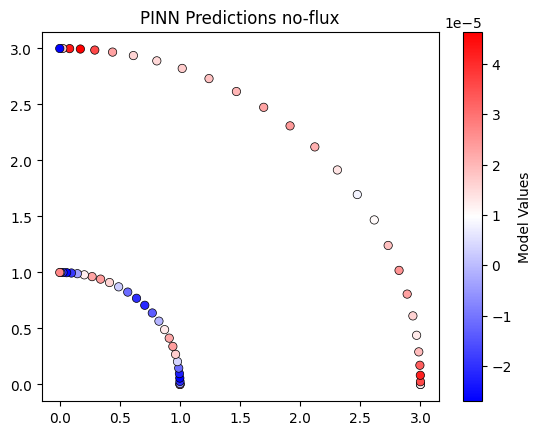

Step: 44000
PDE loss, boundary loss, data loss: (tensor(6.9551e-07, grad_fn=<MeanBackward0>), tensor(4.0196e-10, grad_fn=<AddBackward0>), 0)


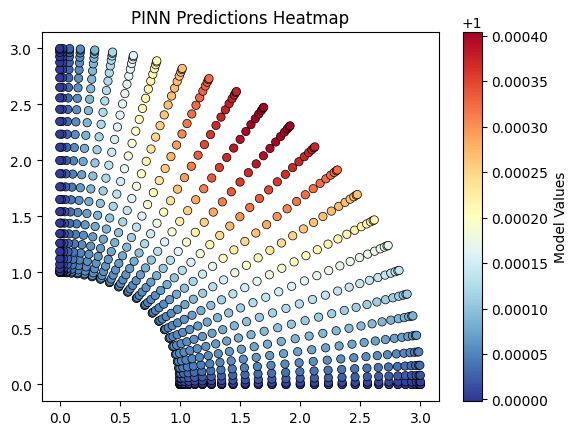

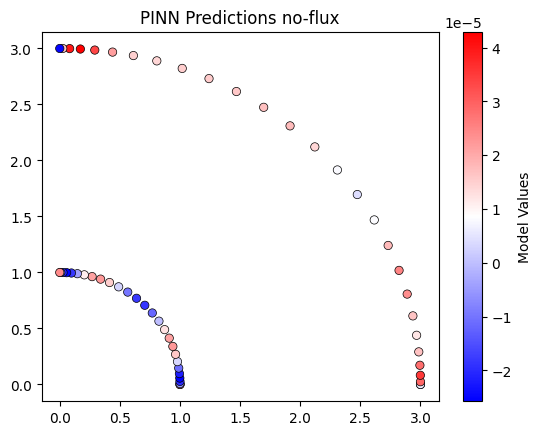

Step: 46000
PDE loss, boundary loss, data loss: (tensor(5.7260e-07, grad_fn=<MeanBackward0>), tensor(3.2358e-10, grad_fn=<AddBackward0>), 0)


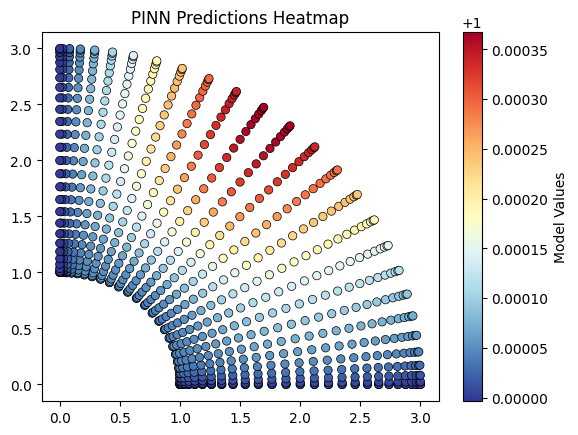

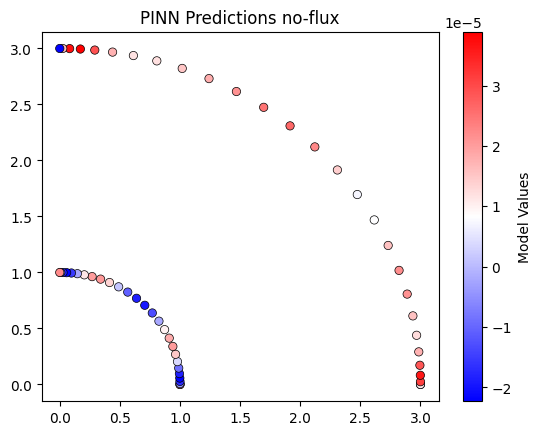

KeyboardInterrupt: 

In [15]:

# Create the training loop. 
# Include training data when available or just use physics loss. 
use_data = False
if use_data:
  data_x = torch.tensor(xs_training)
  data_y = torch.tensor(ys_training)

else:
  data_x = None
  data_y = None

# Define same "random" initialization og weights. 
torch.manual_seed(123)

# Define boundary values. 
inlet_value = 1.0
outlet_value = 1.0

# Define loss weighting. 
pde_weight = 1e-4
boundary_weight = 1.0
data_weight = 1.0

# Convert everything to tensors. 
physics_xys_tensor = torch.tensor(physics_xys, dtype=torch.float32).requires_grad_(True)
# physics_xs_tensor = torch.tensor(physics_xs).requires_grad_(True)
# physics_ys_tensor = torch.tensor(physics_ys).requires_grad_(True)

inlet_xys_tensor = torch.tensor(inlet_xys, dtype=torch.float32)
outlet_xys_tensor = torch.tensor(outlet_xys, dtype=torch.float32)

right_wall_xys_tensor = torch.tensor(right_wall_xys, dtype=torch.float32).requires_grad_(True)
left_wall_xys_tensor = torch.tensor(left_wall_xys, dtype=torch.float32).requires_grad_(True)

normal_vectors_left_tensor = torch.tensor(normal_vectors_left, dtype=torch.float32)
normal_vectors_right_tensor = torch.tensor(normal_vectors_right, dtype=torch.float32)


# Define model.
model = FullyConnected(2, 64, 1)
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-4)
scheduler = StepLR(optimizer2, step_size=2000, gamma=0.95)

for i in range(50000):
  optimizer2.zero_grad()
  # Data loss
  if use_data:
    model_data_values = model(data_xys)
    data_loss = torch.mean((model_data_values - data_values) ** 2) # Mean squared error
  else:
    data_loss = 0

  # Physics loss.
  # get model's results.
  physics_pred_fs = model(physics_xys_tensor)

  # Set tensors for storing gradient outputs. 
  grad_outputs = torch.ones_like(physics_pred_fs)

  # First derivative after both x and y, respectively. 
  grad_f = grad(physics_pred_fs, physics_xys_tensor, grad_outputs=grad_outputs, create_graph=True)[0]

  df_dx = grad_f[:, 0]
  df_dy = grad_f[:, 1]

  # Second derivative after x and y, respectively. 
  nabla_f = grad(grad_f, physics_xys_tensor, grad_outputs=torch.ones_like(grad_f), create_graph=True)[0]

  df_dx2 = nabla_f[:, 0]
  df_dy2 = nabla_f[:, 1]

  # Define PDE residual. 
  pde_residual_loss = torch.mean(nabla_f**2)

  # Set up boundary conditions. 
  # Inlet
  inlet_values = torch.full_like(inlet_xys_tensor, fill_value=inlet_value)
  model_inlet_values = model(inlet_xys_tensor)
  
  inlet_loss = torch.mean((inlet_values - model_inlet_values)**2)

  # Outlet
  outlet_values = torch.full_like(outlet_xys_tensor, fill_value=outlet_value)
  model_outlet_values = model(outlet_xys_tensor)

  outlet_loss = torch.mean((outlet_values - model_outlet_values)**2)

  # Boundary condition on walls. Use zero-flux. 
  right_wall_values = model(right_wall_xys_tensor)
  left_wall_values = model(left_wall_xys_tensor)

  right_wall_grad = grad(right_wall_values, right_wall_xys_tensor, grad_outputs=torch.ones_like(right_wall_values), create_graph=True)[0]
  left_wall_grad = grad(left_wall_values, left_wall_xys_tensor, grad_outputs=torch.ones_like(left_wall_values), create_graph=True)[0]

  flux_left_wall = left_wall_grad[:, 0] * normal_vectors_left_tensor[:, 0] + left_wall_grad[:, 1] * normal_vectors_left_tensor[:, 1]
  flux_right_wall = right_wall_grad[:, 0]  * normal_vectors_right_tensor[:, 0] + right_wall_grad[:, 1] * normal_vectors_right_tensor[:, 1]
  
  left_wall_loss = torch.mean(flux_left_wall**2)
  right_wall_loss = torch.mean(flux_right_wall**2)

  # Compute total boundary loss.
  boundary_loss = inlet_loss + outlet_loss + left_wall_loss + right_wall_loss

  # Compute total physics loss.
  physics_loss = pde_weight * pde_residual_loss + boundary_weight*boundary_loss
  
  loss = pde_weight*pde_residual_loss + boundary_weight*boundary_loss + data_weight*data_loss
  
  loss.backward()
  optimizer2.step()
  scheduler.step()


  # Visualize.
  if (i+1) % 2000 == 0:
    print(f'Step: {i+1}')
    print(f'PDE loss, boundary loss, data loss: {pde_residual_loss, boundary_loss, data_loss}')

    # Show PINNs values. 
    # Detach PIIns values. 
    values = physics_pred_fs.detach().numpy()


    # # Fix interval for heatmap:
    # lower_cutoff = 0.999
    # upper_cutoff = 1.001
    # # Create a normalization object for values within the specified range
    # norm = Normalize(vmin=lower_cutoff, vmax=upper_cutoff, clip=True)

    # scatter = plt.scatter(physics_xys[:, 0], physics_xys[:, 1,], c=values, norm=norm, cmap='RdYlBu_r', edgecolors='k', linewidths=0.5)
    scatter = plt.scatter(physics_xys[:, 0], physics_xys[:, 1,], c=values, cmap='RdYlBu_r', edgecolors='k', linewidths=0.5)
    plt.colorbar(scatter, label='Model Values')
    plt.title("PINN Predictions Heatmap")
    plt.show()

    # Detach flux values for plotting.
    values_right = flux_right_wall.detach().numpy()
    values_left = flux_left_wall.detach().numpy()
    scatter_right = plt.scatter(right_wall_xys[:, 0], right_wall_xys[:, 1], c=values_right, cmap='bwr', edgecolors='k', linewidths=0.5)
    scatter_left = plt.scatter(left_wall_xys[:, 0], left_wall_xys[:, 1], c=values_left, cmap='bwr', edgecolors='k', linewidths=0.5)

    # Fix interval for heatmap:
    # lower_cutoff = -0.005
    # upper_cutoff = 0.005
    # # # Create a normalization object for values within the specified range
    # norm = Normalize(vmin=lower_cutoff, vmax=upper_cutoff, clip=True)
    # Plot
    # scatter_right = plt.scatter(right_wall_xys[:, 0], right_wall_xys[:, 1], c=values_right, norm=norm, cmap='bwr', edgecolors='k', linewidths=0.5)
    # scatter_left = plt.scatter(left_wall_xys[:, 0], left_wall_xys[:, 1], c=values_left, norm=norm, cmap='bwr', edgecolors='k', linewidths=0.5)

    plt.colorbar(scatter_right, label='Model Values')
    # Set axis labels and plot title
    plt.title("PINN Predictions no-flux")
    plt.show()
